<a href="https://colab.research.google.com/github/saleh1312/python/blob/master/Image-captioning%20with%20tensorflow2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
from glob import glob
import cv2
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model, Sequential
import tensorflow.keras.layers as lay
import os
import matplotlib.pyplot as plt

In [3]:
images_path = '/content/drive/MyDrive/kaggle_dataset/flickr8k-sau/Flickr_Data/Images/'
images = glob(images_path+'*.jpg')

caption_path = '/content/drive/MyDrive/kaggle_dataset/flickr8k-sau/Flickr_Data/Flickr_TextData/Flickr8k.token.txt'
captions = open(caption_path, 'rb').read().decode('utf-8').split('\n')

In [4]:
images[0]

'/content/drive/MyDrive/kaggle_dataset/flickr8k-sau/Flickr_Data/Images/381052465_722e00807b.jpg'

In [5]:
captions[0]

'1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .'

read images

In [6]:
samp=1499

In [7]:
from tensorflow.keras.applications import ResNet50
incept_model = ResNet50(include_top=True)
last = incept_model.layers[-2].output
resnet = Model(inputs = incept_model.input,outputs = last)
resnet.trainable=False
resnet.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [8]:
imgs={}
l=0
for i in images:
  if l==samp:
    break
  k=i.split('/')[-1]

  img = cv2.imread(i)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img, (224,224))
  img = img.reshape(1,224,224,3)
  pred = resnet.predict(img).reshape(2048,)

  imgs[k]=pred
  l+=1

read captions


In [9]:
caps={}
for cap in captions:
  try:
    all=cap.split('\t')
    path=all[0][:-2]
    cape=all[1]
  except:
    continue
    
  if path in imgs :
    if path not in caps:
      caps[path]=[cape]
    else:
      caps[path].append(cape)


show some images

In [10]:
p=0
for (k,u) in imgs.items():
  if p==0:
    print(u)
    print(caps[k])
  p+=1

[0.17548223 0.12192754 0.05968547 ... 0.5044442  0.09549875 0.06983219]
['a firetruck fights a fire .', 'a yellow firetruck is parked next to a fire with a man on a ladder pouring water on it', 'Firefighters putting out a big fire .', 'Fireman fighting a fire .', 'People putting out a fire .']


add tokens

In [11]:
for i,c in caps.items():
  for cc in range(len(c)):
    p=c[cc].lower()
    k='<sos> '+p+' <eos>'
    caps[i][cc]=k

create vocabulary

In [12]:
vacob ={}
for i,c in caps.items():
  for cc in range(len(c)):
    words=caps[i][cc].split()
    for w in words:
        if w not in vacob:
            vacob[w]=len(vacob)+1

In [13]:
for i,c in caps.items():
  for cc in range(len(c)):
    words=caps[i][cc].split()
    encoded=[]
    for w in words:
      encoded.append(vacob[w])
    caps[i][cc]=encoded

In [14]:
max=0
for i,c in caps.items():
  for cc in c:
    if max < len(cc):
        max=len(cc)

In [15]:
max=40

In [16]:
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences

In [17]:
xx=[]
yin=[]
yout=[]

for i,c in caps.items():
  for c2 in c:
    for g in range(1,len(c2)):
      yi = [c2[:g]]
      yo = c2[g]

      in_seq = pad_sequences(yi, maxlen=max, padding='post', truncating='post')[0]
      out_seq = to_categorical([yo], num_classes=len(vacob)+1)[0]
        
      xx.append(imgs[i])
      yin.append(in_seq)
      yout.append(out_seq)

In [18]:
xxx = np.array(xx)
y_in = np.array(yin, dtype='float64')
y_out = np.array(yout, dtype='float64')

In [19]:
print(xxx.shape,y_in.shape,y_out.shape)

(96470, 2048) (96470, 40) (96470, 4007)


In [20]:
image_model = Sequential()
image_model.add(lay.Dense(128, input_shape=(2048,), activation='relu'))
image_model.add(lay.RepeatVector(max))

In [21]:
image_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               262272    
_________________________________________________________________
repeat_vector (RepeatVector) (None, 40, 128)           0         
Total params: 262,272
Trainable params: 262,272
Non-trainable params: 0
_________________________________________________________________


In [22]:
language_model = Sequential()
language_model.add(lay.Embedding(input_dim=len(vacob)+1, output_dim=128, input_length=max))
language_model.add(lay.LSTM(256, return_sequences=True))
language_model.add(lay.TimeDistributed(lay.Dense(128)))

In [23]:
conca = lay.Concatenate()([image_model.output, language_model.output])
x = lay.LSTM(128, return_sequences=True)(conca)
x = lay.LSTM(512, return_sequences=False)(x)
out = lay.Dense(len(vacob)+1,activation='softmax')(x)
model = Model(inputs=[image_model.input, language_model.input], outputs = out)

# model.load_weights("../input/model_weights.h5")
model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
embedding_input (InputLayer)    [(None, 40)]         0                                            
__________________________________________________________________________________________________
dense_input (InputLayer)        [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 40, 128)      512896      embedding_input[0][0]            
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          262272      dense_input[0][0]                
____________________________________________________________________________________________

In [25]:
model.fit([xxx, y_in], y_out, batch_size=256, epochs=100)

Epoch 1/100
377/377 [==============================] - 22s 57ms/step - loss: 0.4693 - accuracy: 0.8534
Epoch 2/100
377/377 [==============================] - 22s 58ms/step - loss: 0.4274 - accuracy: 0.8659
Epoch 3/100
377/377 [==============================] - 21s 57ms/step - loss: 0.4078 - accuracy: 0.8707
Epoch 4/100
377/377 [==============================] - 21s 57ms/step - loss: 0.4005 - accuracy: 0.8729
Epoch 5/100
377/377 [==============================] - 21s 57ms/step - loss: 0.3915 - accuracy: 0.8762
Epoch 6/100
377/377 [==============================] - 22s 57ms/step - loss: 0.3853 - accuracy: 0.8763
Epoch 7/100
377/377 [==============================] - 21s 57ms/step - loss: 0.3792 - accuracy: 0.8781
Epoch 8/100
377/377 [==============================] - 21s 57ms/step - loss: 0.3752 - accuracy: 0.8798
Epoch 9/100
377/377 [==============================] - 21s 57ms/step - loss: 0.3695 - accuracy: 0.8806
Epoch 10/100
377/377 [==============================] - 21s 57ms/step - l

In [26]:
model.save('/content/drive/MyDrive/kaggle_dataset/model.h5')

In [42]:
inv_vacob = {v:k for k, v in vacob.items()}

 a smiling man sits on


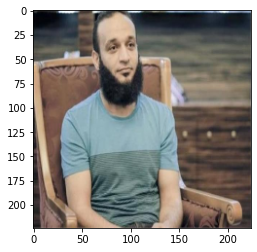

In [47]:
test=cv2.imread('abd2.jpg')
test = cv2.cvtColor(test, cv2.COLOR_BGR2RGB)
test = cv2.resize(test, (224,224))
test = test.reshape(1,224,224,3)
predt = resnet.predict(test).reshape(1,2048)

word=['<sos>']
word_encoded=[]
stement=''
for i in range(5):
  word_encoded=[]
  for w in word:
    word_encoded.append(vacob[w])


  encoded = [word_encoded]
  encoded = pad_sequences(encoded, padding='post', truncating='post', maxlen=max)

  prediction = np.argmax(model.predict([predt, encoded]))

  sampled_word = inv_vacob[prediction]
  if sampled_word == '<eos>':
    break

  word.append(sampled_word)
  stement+=' '+sampled_word

plt.imshow(test.reshape(224,224,3))
print(stement)